# River Tree

An example workflow for gathering NHD Plus data and generating a tree.  This tree can then be iterated over to accumulate data.  Braided systems are merged into a single reach, and the system is simplified relative to NHD Plus's raw format.

This type of workflow is useful for setting up stream network models.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os,sys
import numpy as np
from matplotlib import pyplot as plt
import shapely
import logging

import watershed_workflow
import watershed_workflow.source_list
import watershed_workflow.config
import watershed_workflow.ui
import watershed_workflow.utils
import watershed_workflow.plot

watershed_workflow.ui.setup_logging(1,None)

In [3]:
# open a shapefile for use here
shpfile = os.path.join('Coweeta', 'input_data', 'coweeta_basin.shp')
crs, shply = watershed_workflow.get_shapes(shpfile)
shply = shply[0]

2024-07-18 10:45:22,401 - root - INFO: 
2024-07-18 10:45:22,401 - root - INFO: Loading shapes
2024-07-18 10:45:22,402 - root - INFO: ------------------------------
2024-07-18 10:45:22,402 - root - INFO: Loading file: 'Coweeta/input_data/coweeta_basin.shp'
2024-07-18 10:45:22,415 - root - INFO: ... found 1 shapes
2024-07-18 10:45:22,417 - root - INFO: Converting to shapely
2024-07-18 10:45:22,417 - root - INFO:  ... done


In [4]:
# find the rivers in this shape
_, reaches = watershed_workflow.get_reaches(watershed_workflow.source_list.hydrography_sources['NHD Plus'],
                                            '0601', shply.bounds, crs, crs, merge=False)

# filter rivers to the huc shape
reaches = watershed_workflow.utils.filter_to_shape(shply, reaches)

# make the global tree
rivers = watershed_workflow.hydrography.createGlobalTree(reaches)

# check that only one tree was formed
assert(len(rivers) == 1)
river = rivers[0]

2024-07-18 10:45:22,436 - root - INFO: 
2024-07-18 10:45:22,440 - root - INFO: Loading Hydrography
2024-07-18 10:45:22,441 - root - INFO: ------------------------------
2024-07-18 10:45:22,441 - root - INFO: Loading streams in HUC 0601
2024-07-18 10:45:22,442 - root - INFO:          and/or bounds (273971.0911428096, 3878839.6361173145, 279140.9150949494, 3883953.7853134344)
2024-07-18 10:45:22,442 - root - INFO:   Using Hydrography file "/home/ecoon/code/watershed_workflow/data/hydrography/NHDPlus_H_0601_GDB/NHDPlus_H_0601.gdb"
2024-07-18 10:45:22,443 - root - INFO:   National Hydrography Dataset Plus High Resolution (NHDPlus HR): opening '/home/ecoon/code/watershed_workflow/data/hydrography/NHDPlus_H_0601_GDB/NHDPlus_H_0601.gdb' layer 'NHDFlowline' for streams in '(273971.0911428096, 3878839.6361173145, 279140.9150949494, 3883953.7853134344)'
2024-07-18 10:45:22,552 - root - INFO:   Found total of 35 in bounds.
2024-07-18 10:45:22,552 - root - INFO: Filtering reaches not in-network
20

/home/ecoon/code/miniforge3/envs/watershed-workflow-master-20240429/lib/python3.10/site-packages/pyproj/crs/crs.py:1286: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


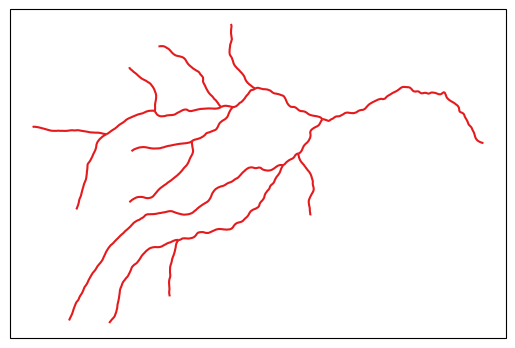

In [5]:
watershed_workflow.plot.rivers([river,], crs)

In [6]:
print('NAME: length')
print('-------------')
gnis_name = 'GNIS_Name' if 'GNIS_Name' in river.properties else 'gnis_name'

for r in river:
    print(f"{r.properties[gnis_name]}: {r.properties['Shape_Length']}")

NAME: length
-------------
Coweeta Creek: 0.02933313696587409
Shope Fork: 0.011570165507744527
None: 0.009894541322192156
Shope Fork: 0.004264916720386313
Cunningham Creek: 0.00785105614440285
Mill Branch: 0.00949783326393551
Cunningham Creek: 0.013625581127194461
Shope Fork: 0.0018043963180130245
Camprock Branch: 0.01301040698009797
Shope Fork: 0.010667588570320843
None: 0.007663308365762772
Shope Fork: 0.008081500797913782
Pinnacle Branch: 0.011390885255323774
Shope Fork: 0.01090783980118138
Ball Creek: 0.006007203236050549
Ball Creek: 0.0028292168551516204
Ball Creek: 0.020068080745982632
None: 0.007426501094440895
Ball Creek: 0.016249967638654387
Henson Creek: 0.041313864451429864
None: 0.008785810565916707


In [7]:
import fiona
gdb = watershed_workflow.source_list.hydrography_sources['NHD Plus'].name_manager.file_name('0601')
fiona.listlayers(gdb)


['ExternalCrosswalk',
 'FeatureToMetadata',
 'HUMod',
 'MetaProcessDetail',
 'MetaSourceDetail',
 'NHDFCode',
 'NHDFeatureToMetadata',
 'NHDMetadata',
 'NHDPlusDivFracMP',
 'NHDPlusEROMMA',
 'NHDPlusEROMQAMA',
 'NHDPlusEROMQARPT',
 'NHDPlusFlow',
 'NHDPlusFlowlineVAA',
 'NHDPlusIncrLat',
 'NHDPlusIncrPrecipMA',
 'NHDPlusIncrPrecipMM01',
 'NHDPlusIncrPrecipMM02',
 'NHDPlusIncrPrecipMM03',
 'NHDPlusIncrPrecipMM04',
 'NHDPlusIncrPrecipMM05',
 'NHDPlusIncrPrecipMM06',
 'NHDPlusIncrPrecipMM07',
 'NHDPlusIncrPrecipMM08',
 'NHDPlusIncrPrecipMM09',
 'NHDPlusIncrPrecipMM10',
 'NHDPlusIncrPrecipMM11',
 'NHDPlusIncrPrecipMM12',
 'NHDPlusIncrROMA',
 'NHDPlusIncrTempMA',
 'NHDPlusIncrTempMM01',
 'NHDPlusIncrTempMM02',
 'NHDPlusIncrTempMM03',
 'NHDPlusIncrTempMM04',
 'NHDPlusIncrTempMM05',
 'NHDPlusIncrTempMM06',
 'NHDPlusIncrTempMM07',
 'NHDPlusIncrTempMM08',
 'NHDPlusIncrTempMM09',
 'NHDPlusIncrTempMM10',
 'NHDPlusIncrTempMM11',
 'NHDPlusIncrTempMM12',
 'NHDPlusMegaDiv',
 'NHDPlusNHDPlusIDGridCode

In [8]:
with fiona.open(gdb, 'r', layer='NHDPlusFlowlineVAA') as fid:
    flowline = fid[10]
flowline

2024-07-18 10:45:22,735 - fiona._env - ERROR: Pointer 'hGeom' is NULL in 'OGR_G_GetGeometryType'.

